<a href="https://colab.research.google.com/github/beyzaturku/Weather_Detection_Using_CNN/blob/main/Weather_Detection_10_Unsuccessful.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!python --version

Python 3.11.11


In [3]:
!pip install opencv-python

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
zip_path = '/content/drive/MyDrive/Weather_Detection/wd_dataset.zip'

In [67]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from tensorflow.keras.regularizers import l2
import warnings
warnings.filterwarnings("ignore")

import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

Google Colab'a dosya yükleme işlemi

In [54]:
from google.colab import files
uploaded = files.upload()

Veri Setini Yükleme

In [6]:
# Assuming 'wd_dataset' is the extracted folder name inside your Google Drive
image_folder = '/content/drive/MyDrive/Weather_Detection/Multi_Class_Weather_Dataset'


subfolders = [ 'Cloudy', 'Rain', 'Shine', 'Sunrise']
label_map = { subfolder: idx for idx, subfolder in enumerate(subfolders)}

# List of Images and Labels
images = []
labels = []

# Loading Dataset
for subfolder in subfolders:
    subfolder_path = os.path.join(image_folder, subfolder)
    for filename in os.listdir(subfolder_path):
        img_path = os.path.join(subfolder_path, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img_resized = cv2.resize(img, (224,224))
            images.append(img_resized)
            labels.append(label_map[subfolder])

# Coverted to Numpy Arrays
images = np.array(images)
labels = np.array(labels)

# Normalize the Images
images = images.astype('float32') / 255.0

Dosya path'lerini kategorilendirme

In [7]:
labels_one_hot = tf.keras.utils.to_categorical(labels, num_classes = len(subfolders))

#labels dizisi, her görüntünün sınıfını belirten sayısal etiketleri içerir.
#labels dizininde bulunan kategori etiketlerini one-hot encoding formatına dönüştürür.

Veri Setini Bölme

In [65]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [42]:
img_size = (224, 224)
batch_size = 50

train_generator = train_datagen.flow_from_directory(
    image_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    image_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 901 images belonging to 4 classes.
Found 224 images belonging to 4 classes.


In [43]:
X_train, X_test, y_train, y_test = train_test_split(images, labels_one_hot, test_size = 0.2, stratify = labels_one_hot, random_state = 42)

In [44]:
print("Training data shape:", X_train.shape, "Training labels shape:", y_train.shape)
print("Test data shape:", X_test.shape, "Test labels shape:", y_test.shape)

Training data shape: (898, 224, 224, 3) Training labels shape: (898, 4)
Test data shape: (225, 224, 224, 3) Test labels shape: (225, 4)


Model Mimarisi Kurma

In [64]:
model = Sequential([

    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),

    Dense(4, activation='softmax')
])

model.summary()





Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 52, 52, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 512)                 │      18,874,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,397,572 (74.00 MB)

 Trainable params: 19,396,612 (73.99 MB)

 Non-trainable params: 960 (3.75 KB)

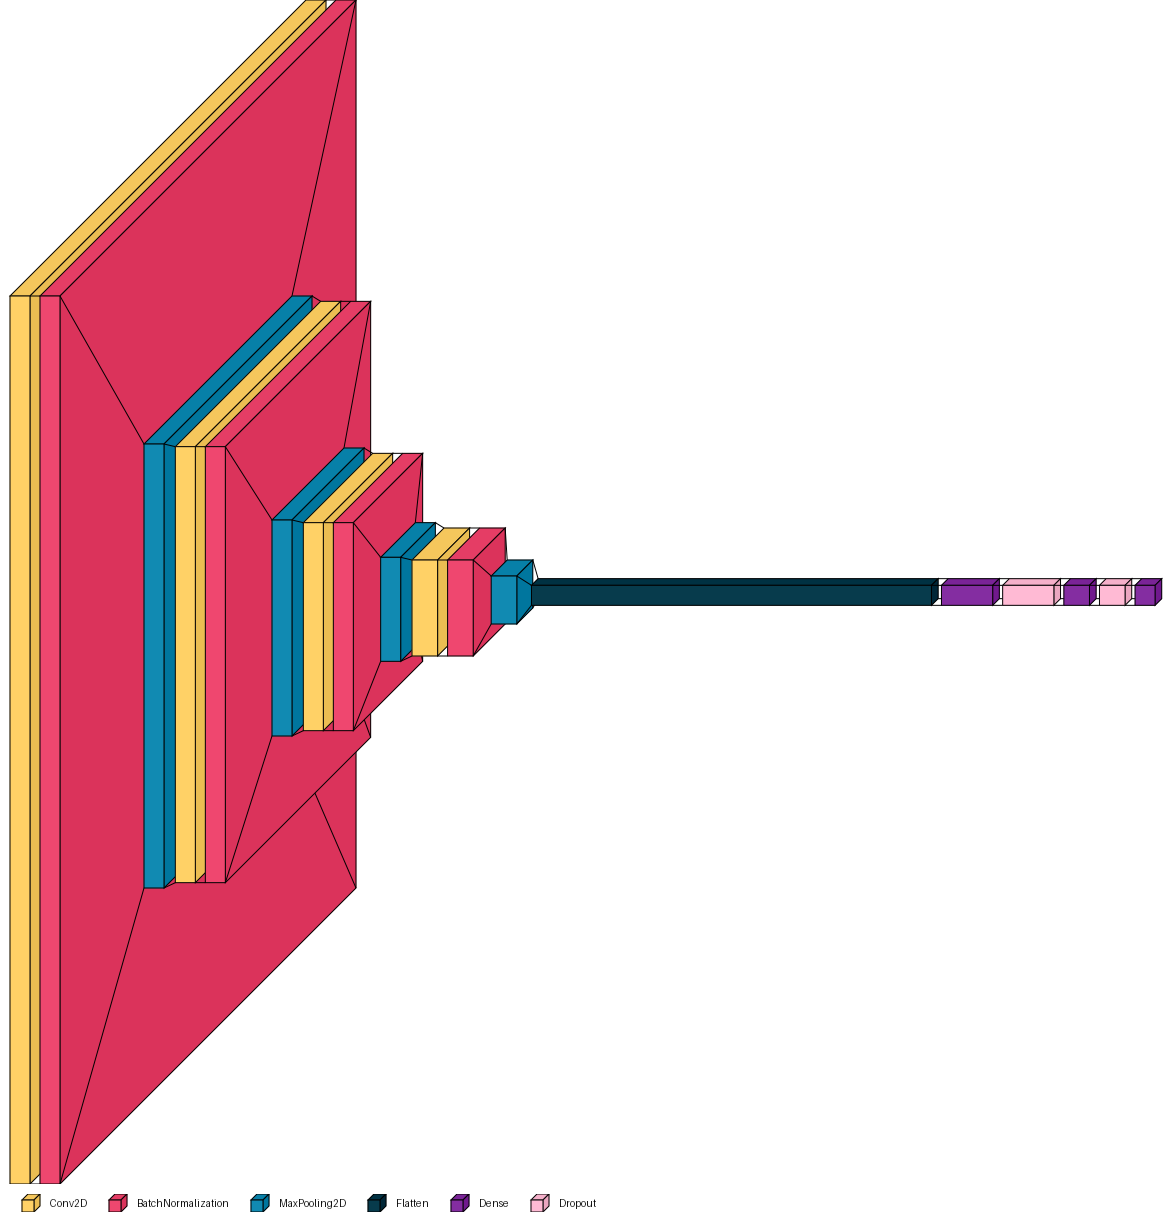

In [72]:
!pip install visualkeras

import visualkeras

visualkeras.layered_view(model, legend=True)

In [68]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [69]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

In [71]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [73]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=50,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.5706 - loss: 7.3455 - val_accuracy: 0.4800 - val_loss: 4.5168 - learning_rate: 0.0010
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.7800 - loss: 6.2560 - val_accuracy: 0.5000 - val_loss: 4.2527 - learning_rate: 0.0010
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 18s 680ms/step - accuracy: 0.8106 - loss: 6.7055 - val_accuracy: 0.4250 - val_loss: 9.2493 - learning_rate: 0.0010
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9000 - loss: 5.5396 - val_accuracy: 0.3750 - val_loss: 11.1001 - learning_rate: 0.0010
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 18s 696ms/step - accuracy: 0.8509 - loss: 5.4193 - val_accuracy: 0.3150 - val_loss: 11.9570 - learning_rate: 0.0010
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7000 - loss: 10.1026 - val_accuracy: 0.2917 - val_loss: 9.0834 - learning_rate: 0.0010
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 18s 725ms/step - accuracy: 0.7055 - loss: 11.0575

Loss artmaya başladığında early stopping ile durdu.

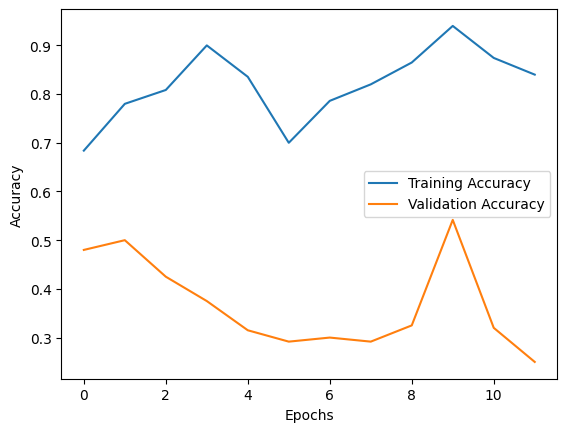

In [74]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()